In [31]:
import pandas as pd
import numpy as np
from scipy import integrate
import scipy.interpolate as spl
import random
from berliner import CMD
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("default")

import sys
sys.path.append('../') # 添加包含functionkit.py文件的目录路径
import functionkit

In [4]:
isoc_file = '../../data/iso_age_8.104_mh_0.006.csv'
isoc = pd.read_csv(isoc_file)

In [107]:
c=CMD()
logage = 10
mh = -1.12

isoc = c.get_one_isochrone(
    logage=logage,     # log age
    z=None,       # if [M/H] is not set, z is used
    mh=mh,        # [M/H]
    photsys_file='ubvrijhk', # photometric system
    )

In [50]:
isoc

Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,McoreTP,C_O,period0,period1,period2,period3,period4,pmode,Mloss,tau1m,X,Y,Xc,Xn,Xo,Cexcess,Z,mbolmag,Umag,Bmag,Vmag,Rmag,Imag,Jmag,Hmag,Kmag
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.014903,0.006,10.0,0.0900000036,25.54494584,0.09,-3.422,3.3631,5.219,1,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-3.91e-17,0.0,0.7089,0.2761,0.002691,0.000726,0.006585,-1.0,0.01497,13.325,22.618,19.983,18.143,15.985,13.733,11.234,10.619,10.331
0.014903,0.006,10.0,0.1000000089,25.7288239022,0.1,-3.239,3.3891,5.185,1,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-2.35e-17,0.0,0.7085,0.2765,0.002691,0.000726,0.006585,-1.0,0.01497,12.867,22.097,19.498,17.667,15.521,13.275,10.777,10.163,9.871
0.014903,0.006,10.0,0.1088699624,25.8592190124,0.109,-3.115,3.4055,5.163,1,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-4.23e-17,0.0,0.7081,0.2769,0.002691,0.000726,0.006585,-1.0,0.01497,12.557,21.747,19.17,17.346,15.208,12.965,10.468,9.854,9.56
0.014903,0.006,10.0,0.1200000048,25.9912975808,0.12,-2.973,3.4243,5.139,1,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-1.04e-16,0.0,0.7076,0.2774,0.002691,0.000726,0.006585,-1.0,0.01497,12.201,20.954,18.526,16.733,14.69,12.512,10.13,9.516,9.218
0.014903,0.006,10.0,0.1400000155,26.1680009127,0.14,-2.79,3.4443,5.103,1,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-1.53e-16,0.0,0.7069,0.2782,0.002691,0.000726,0.006585,-1.0,0.01497,11.744,19.431,17.324,15.618,13.809,11.799,9.72,9.103,8.804
0.014903,0.006,10.0,0.1488189399,26.2284649001,0.149,-2.725,3.4505,5.089,1,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-1.75e-16,0.0,0.7066,0.2785,0.002691,0.000726,0.006585,-1.0,0.01497,11.582,18.965,16.946,15.265,13.523,11.566,9.572,8.955,8.657
0.014903,0.006,10.0,0.1599999964,26.293995795,0.16,-2.648,3.4579,5.073,1,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-2.06e-16,0.0,0.7062,0.2789,0.002691,0.000726,0.006585,-1.0,0.01497,11.39,18.422,16.504,14.845,13.183,11.296,9.399,8.781,8.485
0.014903,0.006,10.0,0.2000000179,26.4598966853,0.2,-2.428,3.4766,5.026,1,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-3.22e-16,0.0,0.7051,0.28,0.002691,0.000726,0.006585,-1.0,0.01497,10.84,17.082,15.379,13.779,12.299,10.579,8.895,8.275,7.987
0.014903,0.006,10.0,0.25,26.5826462033,0.25,-2.215,3.4929,4.975,1,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-7.14e-17,0.0,0.7042,0.2808,0.002691,0.000726,0.006585,-1.0,0.01497,10.308,15.967,14.411,12.847,11.498,9.931,8.403,7.781,7.504


In [108]:
# 初始质量函数
# generate the mass catalog follow the selected IMF 
def fun_IMF(m_x,label='Kroupa'):
    '''
    Initial Mass Funcation
    label = ['Salpeter','Kroupa','Chabrier']
    '''
    while label == 'Salpeter':
        if m_x < 0.1:
            return 0
        elif m_x < 100:
            return m_x**(-2.35)
        else : 
            return 0
    
    while label == 'Kroupa':
        if m_x < 0.08 : 
            return 0
        elif m_x < 0.5 : 
            return 2*m_x**(-1.3)
        elif m_x < 150:
            return m_x**(-2.3)
        else :
            return 0
        
        
    while label == 'Chabrier':
        if m_x < 0.07 : 
            return 0
        elif m_x < 1.0 : 
            return m_x**(-1.55)
        elif m_x < 100 : 
            return m_x**(-2.7)
        else : 
            return 0

# 返回IMF的pdf       
def pdf_IMF(m_x,m_min,m_max,label='Kroupa'):
    if m_x < m_min or m_x > m_max:
        return 0
    else : 
        return fun_IMF(m_x,label)/integrate.quad(lambda x : fun_IMF(x,label), m_min, m_max)[0]

# 按照 初始质量函数 随机生成 m_n 个范围在 (m_min,m_max) 之间的质量 
def random_IMF(m_n, m_min, m_max,label='Kroupa'):
    m_result = []
    c = pdf_IMF(m_min, m_min, m_max, label)
    for i in range(m_n):
        m_flag = 0 # 标志，判断生成的 mass 是否已经到达设定的质量上限 m_max
        while m_flag == 0:
            m_x = random.uniform(m_min, m_max) # 从(m_min, m_max)的均匀分布中随机抽取一个数
            m_y = random.uniform(0,1) 
            if m_y < pdf_IMF(m_x, m_min, m_max, label)/c: 
                m_result.append(m_x)
                m_flag = 1
    return m_result

In [99]:
isoc.pprint_all()

   Zini     MH  logAge     Mini        int_IMF     Mass  logL  logTe   logg label McoreTP  C_O  period0 period1 period2 period3 period4 pmode   Mloss   tau1m   X      Y        Xc        Xn        Xo    Cexcess     Z     mbolmag  Umag   Bmag   Vmag   Rmag   Imag   Jmag   Hmag   Kmag 
---------- ---- ------ ------------ ------------- ----- ------ ------ ----- ----- ------- ----- ------- ------- ------- ------- ------- ----- --------- ----- ------ ------ --------- --------- --------- ------- --------- ------- ------ ------ ------ ------ ------ ------ ------ ------
0.00015547 -2.0   10.0 0.0936335474 25.6171041391 0.094 -3.051 3.5131 5.464     1     0.0 0.545     0.0     0.0     0.0     0.0     0.0    -1 -6.77e-17   0.0  0.748 0.2519 2.943e-05 7.939e-06 7.201e-05    -1.0 0.0001636  12.397 18.269 16.062 14.159 12.828 11.615 10.497 10.213 10.138
0.00015547 -2.0   10.0 0.0987751186 25.7086407931 0.099 -2.892 3.5353 5.417     1     0.0 0.545     0.0     0.0     0.0     0.0     0.0    -1    -1e

In [109]:
labelIMF='Kroupa'
bands = ['Bmag','Vmag']
dist_mod = 14.4 # 距离模数, dist in unit "Mpc"
fbin=0.35 # 双星比

temiso = isoc
tem = temiso
tem = tem[(tem['label']>0)&(tem['label']<=7)] # MS ~ EAGB

logAge = tem['logAge'][0]
MH = tem['MH'][0]
#tem['Vmag_obs'] = tem['Vmag'] + dist_mod

massmin = 0.66# min(tem[]['Mini'])
massmax = max(tem['Mini'])

# 质量
mass = random_IMF(10000,massmin,massmax,label=labelIMF) # 生成初始质量 primass 
cat = pd.DataFrame(np.zeros((10000,1)),columns=['primass']) # 创建星表
cat['primass'] = mass
cat['age'] = logAge
cat['mh'] = MH

# 双星系统
secindex = random.sample(list(cat.index),k=int(len(cat)*fbin)) # 按双星比 fbin 随机抽取为双星系统的样本
cat['secmass'] = np.zeros(len(cat))
bintem = temiso[temiso['label']==1] # MS 主序
secmass = random_IMF(int(len(cat)*fbin),bintem['Mini'].min(),bintem['Mini'].max(),label=labelIMF) # 生成双星中伴星的初始质量
cat['secmass'][secindex] = secmass # 双星系统中伴星的质量

In [136]:
from astropy.table import Table
isoc = Table.from_pandas(isoc)

In [137]:
isochrone = isoc[(isoc['label']>=0) & (isoc['label']<=7)].to_pandas()

In [127]:
a1 = isoc[isoc['Vmag']<=18].sort_values(by=['Vmag'],ascending=False)

In [142]:
isoc = isochrone
type(isoc)

pandas.core.frame.DataFrame

In [143]:
min(isoc[isoc['Vmag']<=18]['Mini'])

0.0900000036

In [134]:
p = a1['Mini'] - a2['Mini']
p[p!=0]

Series([], Name: Mini, dtype: float64)

In [91]:
d=7500
5*np.log10(d)-5

14.3753063169585

In [90]:
massmin

0.0936335474

In [110]:
# 流量
for band in bands:
    cat['%s_pri'%(band)] = np.zeros(len(cat))
    cat['%s_sec'%(band)] = np.zeros(len(cat))
    
    if tem['label'][-1] <= 3: # MS,SGB,RGB, 如果等时线样本 tem 的阶段到RGB为止
        iso1 = tem
        fmass_band1 = spl.interp1d(iso1['Mini'],iso1['%s'%(band)]) # 拟合流量-质量关系函数
        for h in range(len(cat)):
            cat['%s_pri'%(band)][h] = fmass_band1(cat['primass'][h]) # 给 cat 表中对应的 primass 赋流量值
        # 对单星，真实流量为其本身的流量
        cat['%s_true'%(band)] = cat['%s_pri'%(band)]
        # 对双星系统
        for h in secindex: 
            cat['%s_sec'%(band)][h] = fmass_band1(cat['secmass'][h]) # 按照伴星的质量 secmass 赋伴星的流量值
            cat['%s_true'%(band)][h] = -2.5*np.log10(pow(10,-0.4*cat['%s_pri'%(band)][h])+pow(10,-0.4*cat['%s_sec'%(band)][h])) # 对双星系统，真实流量由主星和伴星共同贡献
            
    if tem['label'][-1]>3: # CHEB, CHEB_b, CHEB_r, EAGB, 如果等时线样本 tem 存在演化到 RGB 后的阶段 
        iso1 = tem[tem['label']<=3] # MS,SGB,RGB
        fmass_band1 = spl.interp1d(iso1['Mini'],iso1['%s'%(band)],fill_value='extrapolate')
               
        iso2 = tem[tem['label']>=4] # CHEB-EAGB,core He-burning, not include TP-AGB
        fmass_band2 = spl.interp1d(iso2['Mini'],iso2['%s'%(band)])
        
        mass_cut = iso2['Mini'].min() # CHEB 开始时的质量
        
        for h in range(len(cat)):
            if cat['primass'][h] < mass_cut: # 若初始质量 primass < EAGB 开始时的质量(处于 MS-RGB 阶段)
                cat['%s_pri'%(band)][h] = fmass_band1(cat['primass'][h]) # 按照 MS-RGB 阶段的流量-质量关系赋值
            else : # 处于 CHEB-EAGB 阶段
                cat['%s_pri'%(band)][h] = fmass_band2(cat['primass'][h]) 
        # 对单星，真实流量为其本身的流量
        cat['%s_true'%(band)] = cat['%s_pri'%(band)]
        # 对双星系统
        for h in secindex:
            if cat['secmass'][h] < mass_cut:
                cat['%s_sec'%(band)][h] = fmass_band1(cat['secmass'][h])
            else : 
                cat['%s_sec'%(band)][h] = fmass_band2(cat['secmass'][h])
            cat['%s_true'%(band)][h] = -2.5*np.log10(pow(10,-0.4*cat['%s_pri'%(band)][h])+pow(10,-0.4*cat['%s_sec'%(band)][h]))           

In [111]:
def ferr_mag(x,factor=0.001): # 模糊因子
    return x*factor
# 流量的误差
for band in bands:
    cat['%s'%(band)] = cat['%s_true'%(band)] + dist_mod # 1、改正距离模数
    # uncertainties 无信息(无UNCER_FIT.csv文件)，定义 ferr_mag 函数代替
    # ferr_mag = spl.interp1d(uncer['mag'],uncer['%s_err'%(band)],fill_value='extrapolate')
    cat['%s_obs'%(band)] = np.zeros(len(cat))

    for i in range(len(cat)):
        temmag = cat['%s'%(band)][i] # 改正距离模数后的流量
        temerr = ferr_mag(temmag) # 再现 color spread, 流量的“人造误差”
        cat['%s_obs'%(band)][i] = random.gauss(temmag,temerr) # 2、观测流量从 N(temmag,temerr) 随机抽样获得     
    cat['%s_err'%(band)] = cat['%s_obs'%(band)]-cat['%s'%(band)] # 流量的实际误差
    
# 保留 ｜流量误差｜< 0.5 的数据
for band in bands:
    cat = cat[(cat['%s_err'%(band)]<0.5)&(cat['%s_err'%(band)]>-0.5)].reset_index(drop=True)

In [15]:
# 不完备性, 没做
# apply completeness map to the ssp with uncertainties 
# xbins = np.arange(float(config['OBJECT']['XMIN']),float(config['OBJECT']['XMAX']),float(config['OBJECT']['XBINSIZE']))
# ybins = np.arange(float(config['OBJECT']['YMIN']),float(config['OBJECT']['YMAX']),float(config['OBJECT']['YBINSIZE']))
# grid_x,grid_y = np.meshgrid(xbins,ybins)
# grid_z = np.zeros((len(ybins),len(xbins))) 

cat['color_obs'] = cat['%s_obs'%(bands[0])] - cat['%s_obs'%(bands[1])] # F606Wmag_obs - F814Wmag_obs
cat['mag_obs'] =  cat['%s_obs'%(bands[1])] # F814Wmag_obs

In [16]:
temcat = cat.dropna()

/tmp/ipykernel_3108576/1431459741.py:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  ax.scatter(cat['Bmag_obs'][index]-cat['Vmag_obs'][index], cat['Vmag_obs'][index],s=0.5,c='k',alpha=1,label='N = %d'%len(cat))
/tmp/ipykernel_3108576/1431459741.py:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  ax.scatter(cat['Bmag_obs'][index]-cat['Vmag_obs'][index], cat['Vmag_obs'][index],s=0.5,c='k',alpha=1,label='N = %d'%len(cat))
/tmp/ipykernel_3108576/1431459741.py:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  ax.scatter(cat['Bmag_obs'][index]-cat['Vmag_obs'][index], cat['Vmag_obs'][index],s=0.5,c='k',alpha=1,label='N = %d'%len(cat))


(-0.1, 2.0)

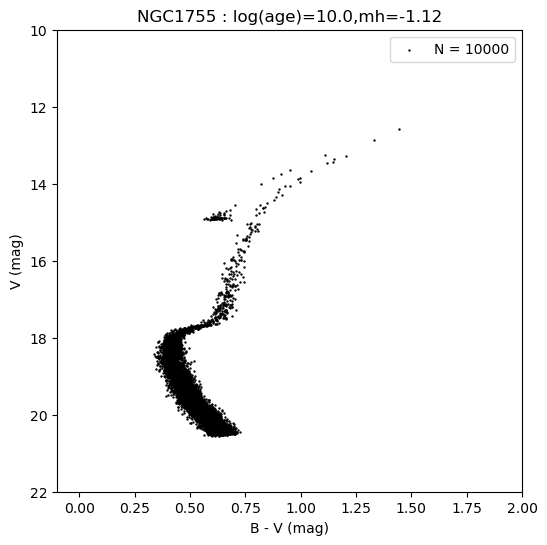

In [174]:
index = set(range(len(cat))) - set(np.where(cat['secmass']>0)[0])
MS = np.where((isoc['label']==1))[0] # main sequence
SGB = np.where((isoc['label']==2))[0] # subgiant branch, or Hertzsprung gap for more intermediate+massive stars
RGB = np.where((isoc['label']==3))[0] # red giant branch, or the quick stage of red giant for intermediate+massive stars
CHEB = np.where((isoc['label']==4))[0] # core He-burning for low mass stars, or the very initial stage of CHeB for intermediate+massive stars
CHEB_b = np.where((isoc['label']==5))[0] # the blueward part of the Cepheid loop of intermediate+massive stars
CHEB_r = np.where((isoc['label']==6))[0] # the redward part of the Cepheid loop of intermediate+massive stars
EAGB = np.where((isoc['label']==7))[0] # the early asymptotic giant branch, or a quick stage of red giant for massive stars

name='NGC1755'
fig,ax =plt.subplots(figsize=(6,6))
ax.scatter(cat['Bmag_obs'][index]-cat['Vmag_obs'][index], cat['Vmag_obs'][index],s=0.5,c='k',alpha=1,label='N = %d'%len(cat))
# ax.plot(isoc["Bmag"][MS]-isoc["Vmag"][MS], isoc["Vmag"][MS]+dist_mod, color='green', label='main sequence')
# ax.plot(isoc["Bmag"][SGB]-isoc["Vmag"][SGB], isoc["Vmag"][SGB]+dist_mod, color='orange', label='subgiant branch')
# ax.plot(isoc["Bmag"][RGB]-isoc["Vmag"][RGB], isoc["Vmag"][RGB]+dist_mod, color='red', label='red giant branch')
# ax.plot(isoc["Bmag"][CHEB]-isoc["Vmag"][CHEB], isoc["Vmag"][CHEB]+dist_mod, color='blue', label='core He-burning')
# ax.plot(isoc["Bmag"][CHEB_b]-isoc["Vmag"][CHEB_b], isoc["Vmag"][CHEB_b]+dist_mod, color='skyblue', label='blueward Cepheid loop')
# ax.plot(isoc["Bmag"][CHEB_r]-isoc["Vmag"][CHEB_r], isoc["Vmag"][CHEB_r]+dist_mod, color='pink', label='redward Cepheid loop')
# ax.plot(isoc["Bmag"][EAGB]-isoc["Vmag"][EAGB], isoc["Vmag"][EAGB]+dist_mod, color='purple', label='early asymptotic giant branch')
ax.invert_yaxis()
ax.legend()
ax.set_title('%s : log(age)=%s,mh=%s'%(name,str(logAge),str(MH)))
ax.set_xlabel("B - V (mag)")
ax.set_ylabel("V (mag)")
ax.set_ylim(22,10)
ax.set_xlim(-0.1,2)

(array([131., 101., 116., 136., 105., 130., 105., 107., 102., 124., 120.,
        130., 119., 124., 116., 109., 138., 115., 106., 110., 111., 124.,
         95., 112., 121., 112., 106., 116., 103., 100., 103., 102.,  86.,
        113., 109.,  96.,  77.,  89.,  96.,  94.,  98., 105., 104., 103.,
         96.,  95., 106., 104., 101., 102.,  96.,  94.,  78.,  84.,  91.,
         89., 102.,  93.,  77.,  95.,  88.,  91.,  93.,  93.,  75.,  92.,
         82.,  66., 100.,  73.,  90.,  63.,  73.,  77.,  83.,  75.,  85.,
         72.,  86.,  97.,  71.,  53.,  73.,  62.,  73.,  62.,  53.,  50.,
         45.,  64.,  59.,  50.,  52.,  53.,  46.,  55.,  45.,  38.,  46.,
         46.]),
 array([-1.02837663, -1.01882338, -1.00927012, -0.99971687, -0.99016361,
        -0.98061036, -0.97105711, -0.96150385, -0.9519506 , -0.94239735,
        -0.93284409, -0.92329084, -0.91373758, -0.90418433, -0.89463108,
        -0.88507782, -0.87552457, -0.86597132, -0.85641806, -0.84686481,
        -0.83731155, -0.82

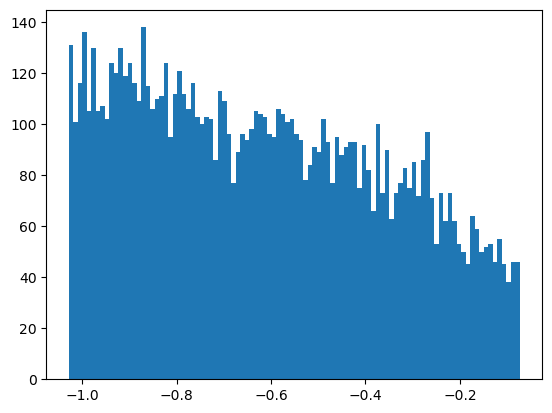

In [87]:
plt.hist(np.log10(cat['primass']),bins=100)

(0.82, 0.88)

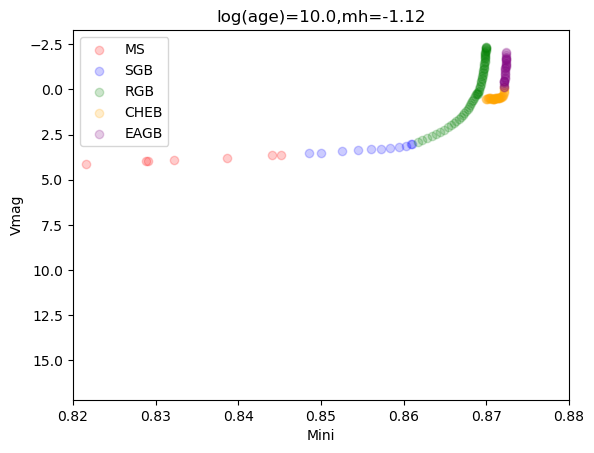

In [186]:
fig,ax = plt.subplots()
#ax.scatter(temiso['Mini'],temiso['Vmag'])
ax.scatter(temiso[temiso['label']==1]['Mini'],temiso[temiso['label']==1]['Vmag'],c='red',label='MS',alpha=0.2)
ax.scatter(temiso[temiso['label']==2]['Mini'],temiso[temiso['label']==2]['Vmag'],c='blue',label='SGB',alpha=0.2)
ax.scatter(temiso[temiso['label']==3]['Mini'],temiso[temiso['label']==3]['Vmag'],c='green',label='RGB',alpha=0.2)
ax.scatter(temiso[temiso['label']==4]['Mini'],temiso[temiso['label']==4]['Vmag'],c='orange',label='CHEB',alpha=0.2)
# ax.scatter(temiso[temiso['label']==5]['Mini'],temiso[temiso['label']==5]['Vmag'],c='grey',label='CHEB_b')
# ax.scatter(temiso[temiso['label']==6]['Mini'],temiso[temiso['label']==6]['Vmag'],c='grey',label='CHEB_r') # 5,6 实际上没有
ax.scatter(temiso[temiso['label']==7]['Mini'],temiso[temiso['label']==7]['Vmag'],c='purple',label='EAGB',alpha=0.2)
ax.legend()
ax.invert_yaxis()
ax.set_xlabel('Mini')
ax.set_ylabel('Vmag')
ax.set_title('log(age)=%s,mh=%s'%(str(logAge),str(MH)))
ax.set_xlim(0.82,0.88)

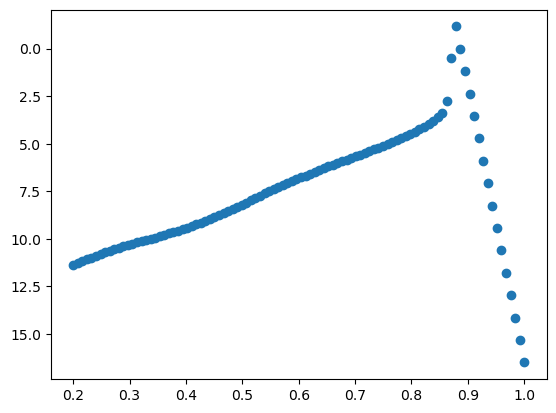

In [152]:
f = spl.interp1d(temiso['Mini'],temiso['Vmag'])
m = np.linspace(0.2,1,100)
v = f(m)
fig,ax = plt.subplots()
ax.scatter(m,v)
ax.invert_yaxis()

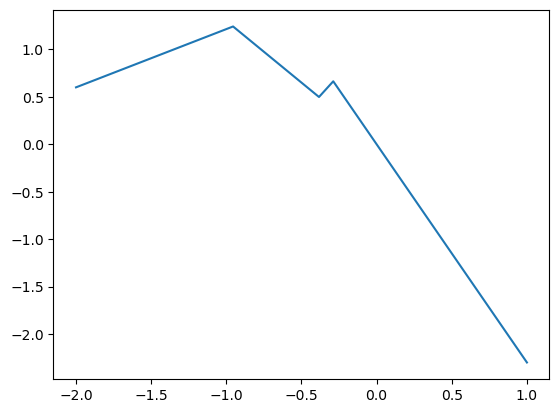

In [77]:
x = np.linspace(0.01,10,100)
def imf(x):
    if x<0.08:
        alpha=0.3
    elif 0.08<x<0.5:
        alpha=1.3
    elif 0.5<x:
        alpha=2.3
    return x**-alpha
#imf = lambda x: x ** -1.3 if x < 0.5 else x ** -2.3
plt.plot(np.log10(x),np.log10([imf(_) for _ in x]))

/tmp/ipykernel_3108576/104844189.py:12: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(x),np.log10([imf(_) for _ in x]))


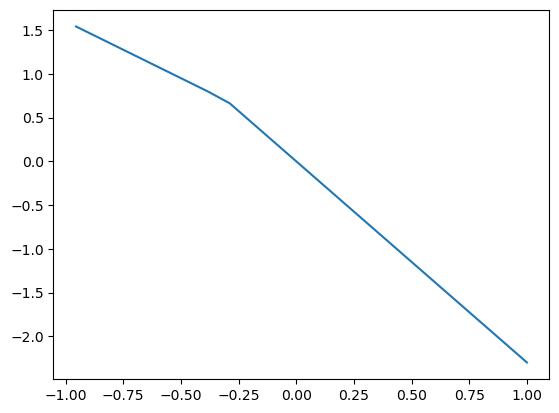

In [80]:
x = np.linspace(0.01,10,100)
def imf(m_x):
    if m_x < 0.08 : 
        return 0
    elif m_x < 0.5 : 
        return 2*m_x**(-1.3)
    elif m_x < 150:
        return m_x**(-2.3)
    else :
        return 0
#imf = lambda x: x ** -1.3 if x < 0.5 else x ** -2.3
plt.plot(np.log10(x),np.log10([imf(_) for _ in x]))